# PyMC-Marketing Geo-Level MMM

In this post, we build a geo-level Marketing Mix Model (MMM) using `pymc-marketing` on a large-scale dataset to evaluate its performance in estimating true marketing contributions. We'll compare the model's inferred contributions against known ground truth, providing a realistic assessment of its accuracy. Additionally, we profile the model's runtime and memory usage to understand its scalability in production-like settings.

In [1]:
import warnings
from pympler import asizeof
import re

from statsmodels.stats.stattools import durbin_watson
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import time

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=UserWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### The Data

To be replaced with a larger dataset, generated by Luca.

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"]).rename(columns={"date_week": "date"})

a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])

data_df.head()

,date,y,x1,x2,event_1,event_2,dayofyear,t,geo
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0,geo_a
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1,geo_a
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2,geo_a
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3,geo_a
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4,geo_a


### Prior Specification 

- Using spend shares as prior for $/beta$ parameters, independent across all geo's.
- Hierarchical structure accross the saturation parameters.

In [4]:
channel_columns = [col for col in data_df.columns if re.fullmatch(r"x\d+", col)]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
)

prior_sigma = n_channels * spend_share

In [5]:
model_config = {
    'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("control", "geo"))
}

In [6]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("LogNormal", mu=np.log(3), sigma=np.log(1.5), dims="channel"),
            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="channel"),
            dims=("channel", "geo"),
        ),
    }
)

### Model Specification & Configuration
- Uses default priors across everything but the saturation params.

**Model Specification**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [7]:
# Base MMM model specification
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=channel_columns,
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    saturation=saturation,
    adstock = GeometricAdstock(l_max = 8),
    yearly_seasonality=2,
    model_config = model_config
)

In [8]:
mmm.model_config

{'intercept': Prior("Normal", mu=0, sigma=2, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims="geo"),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("control", "geo")),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3),
 'saturation_lam': Prior("Gamma", mu=Prior("LogNormal", mu=1.0986122886681098, sigma=0.4054651081081644, dims="channel"), sigma=Prior("LogNormal", mu=0.0, sigma=0.4054651081081644, dims="channel"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

### Data Preparation & Model Building

In [9]:
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [10]:
mmm.build_model(X=x_train, y=y_train)

In [11]:
# Add deterministic terms to recover the component contributions in the original scale.
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

### Prior Predictive Checks

In [12]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, y=y_train, samples=1_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma]


In [13]:
scalers = mmm.get_scales_as_xarray()

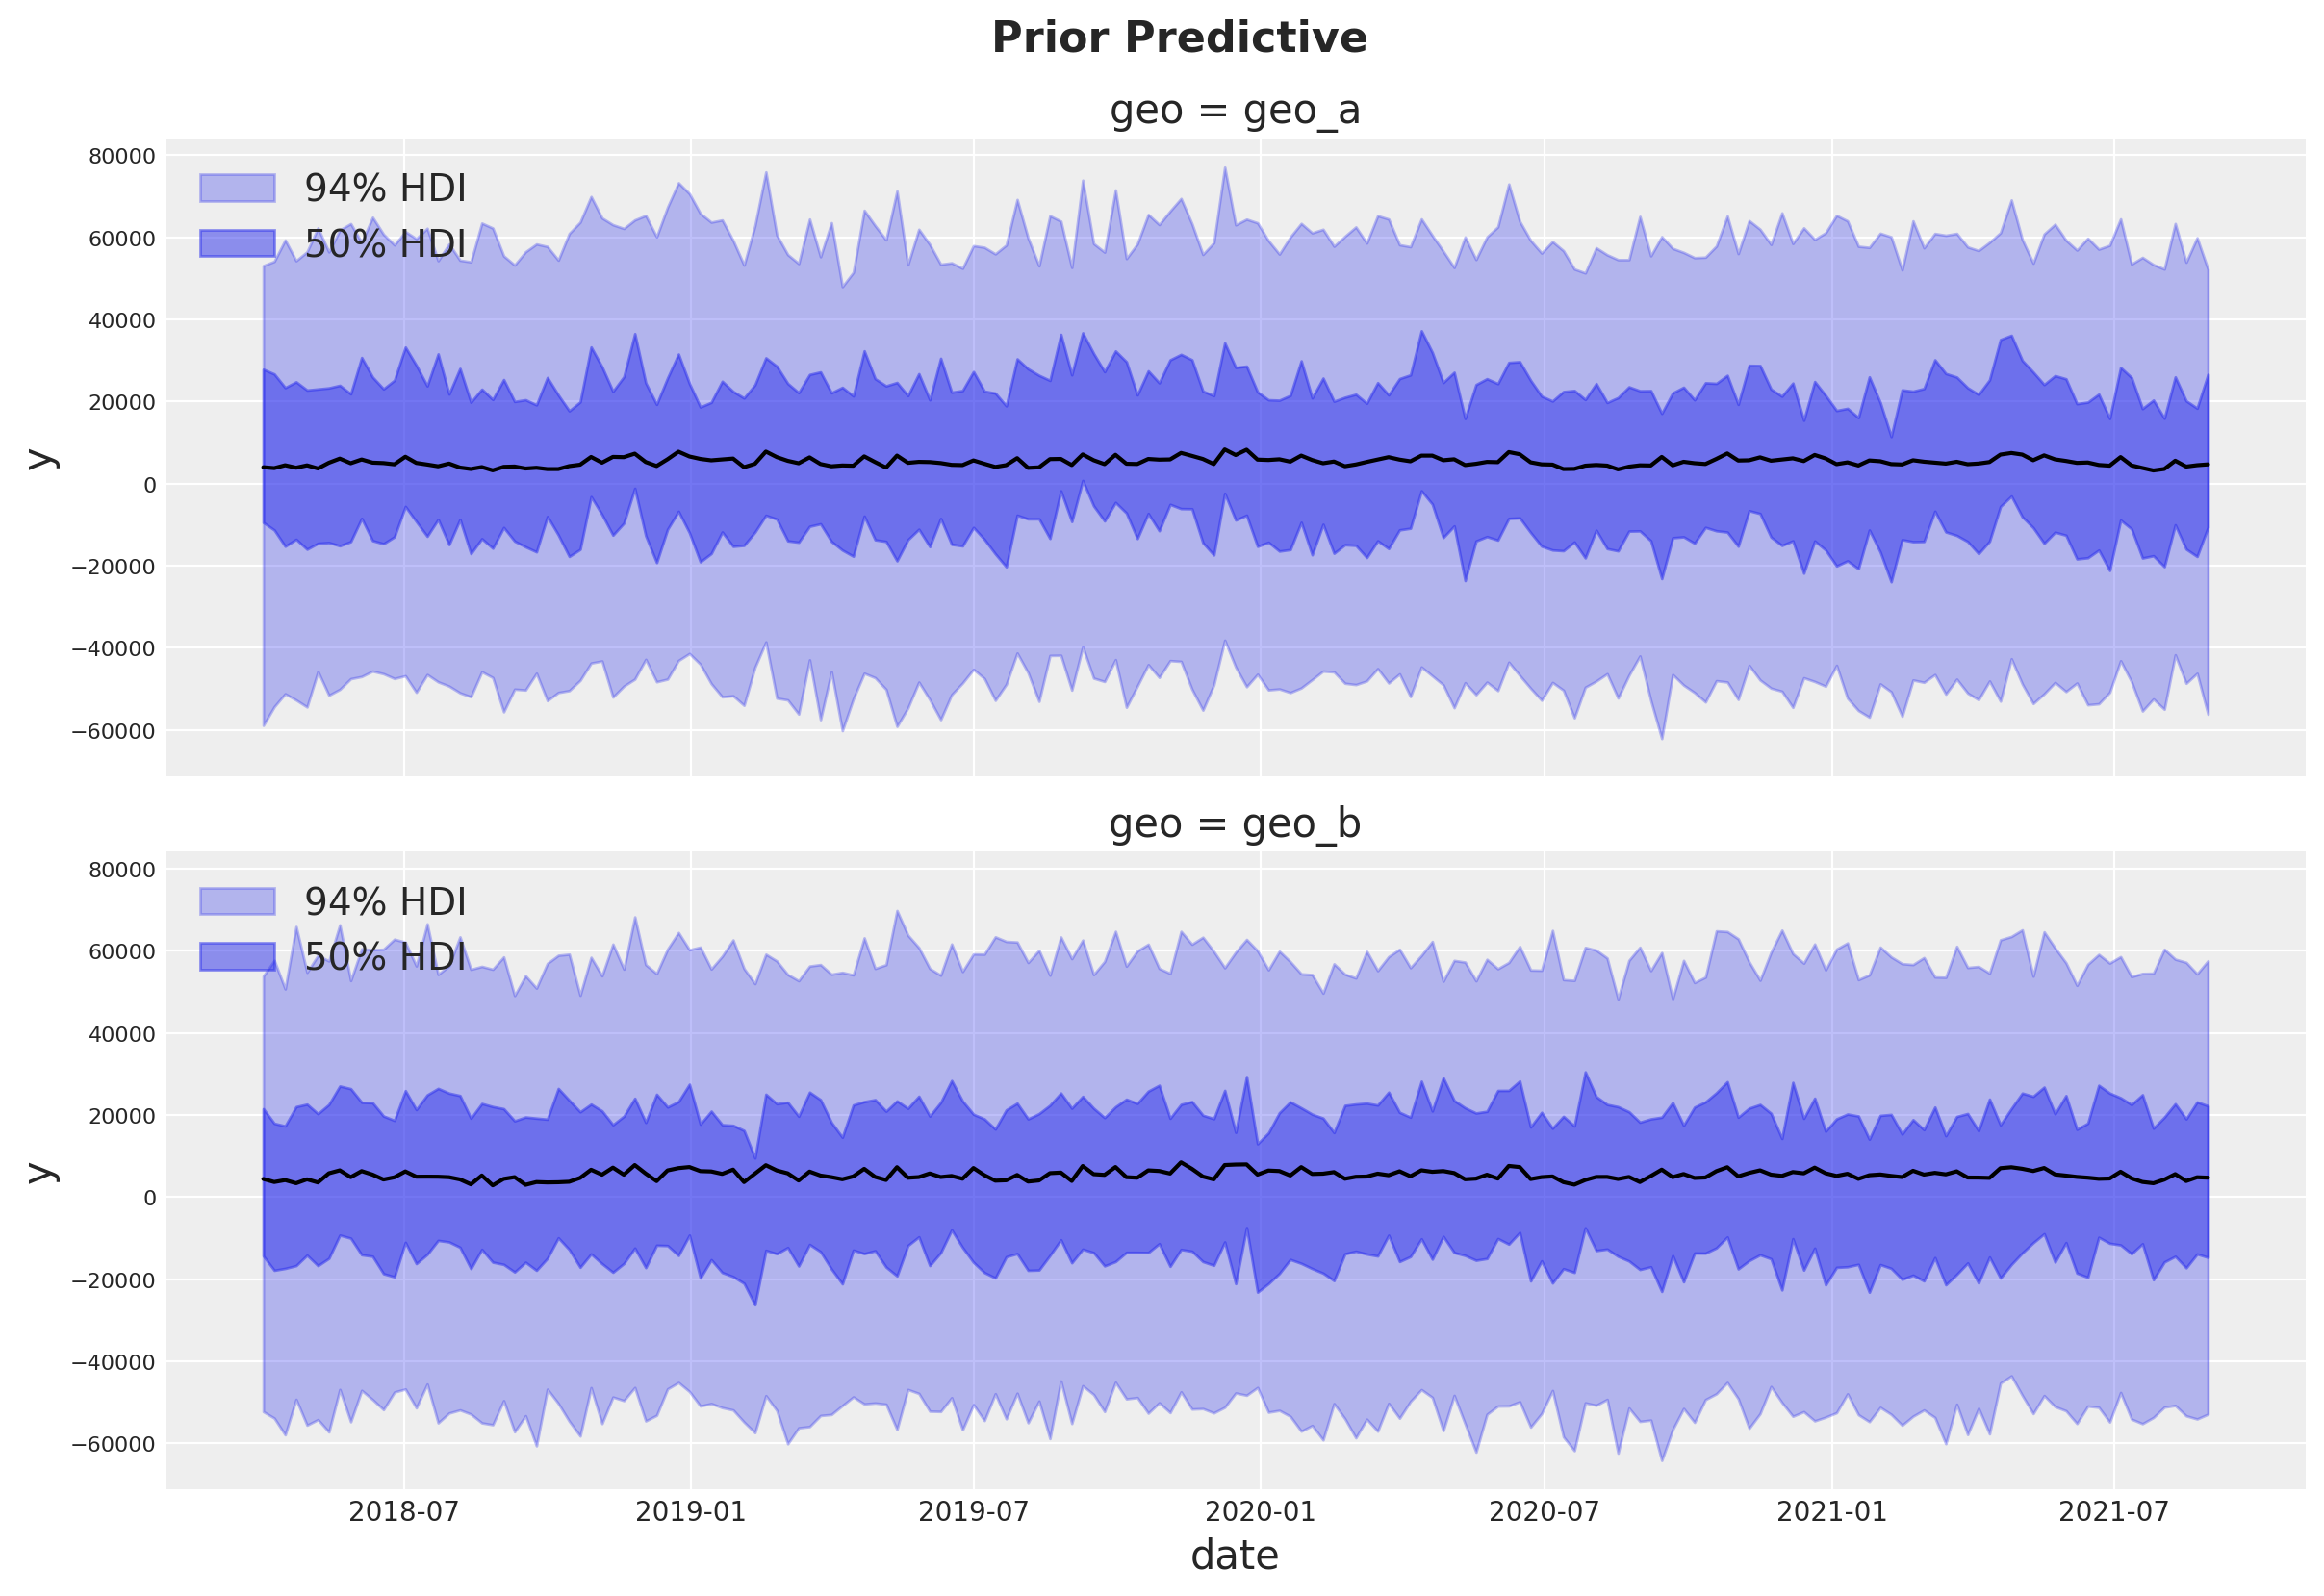

In [14]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

axes = g.axes.flatten()

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    az.plot_hdi(
        x=mmm.model.coords["date"],
        # We need to scale the prior predictive to the original scale to make it comparable to the data.
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    ax.legend(loc="upper left")

g.figure.suptitle("Prior Predictive", fontsize=16, fontweight="bold", y=1.03);

### Model Fitting
- Inspects convergence.
- Calculates run speed.
- Calculates memory footprint.

In [15]:
start = time.perf_counter()

mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    target_accept=0.95,
    random_seed=rng,
)

end = time.perf_counter()
print(f"Sampling took {end - start:.2f} seconds")

start = time.perf_counter()

mmm.sample_posterior_predictive(
    X=x_train,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

end = time.perf_counter()
print(f"Sampling the posterior predictive took {end - start:.2f} seconds")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam_mu, saturation_lam_sigma, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Sampling: [y]


Output()

Sampling took 23.64 seconds


Sampling the posterior predictive took 0.21 seconds


In [16]:
divergences = mmm.idata.sample_stats.diverging.sum().item()
print(f"Number of divergences: {divergences}")

r_hat_max = az.summary(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam_mu",
        "saturation_lam_sigma",
        "saturation_lam",
        "y_sigma",
    ],
)['r_hat'].max()

print(f"Maximum r_hat: {r_hat_max}")

Number of divergences: 0
Maximum r_hat: 1.0


In [17]:
model_size = asizeof.asizeof(mmm)
print(f"Model size: {model_size / (1024 ** 2):.2f} MB")

Model size: 211.65 MB


### Predictive Performance

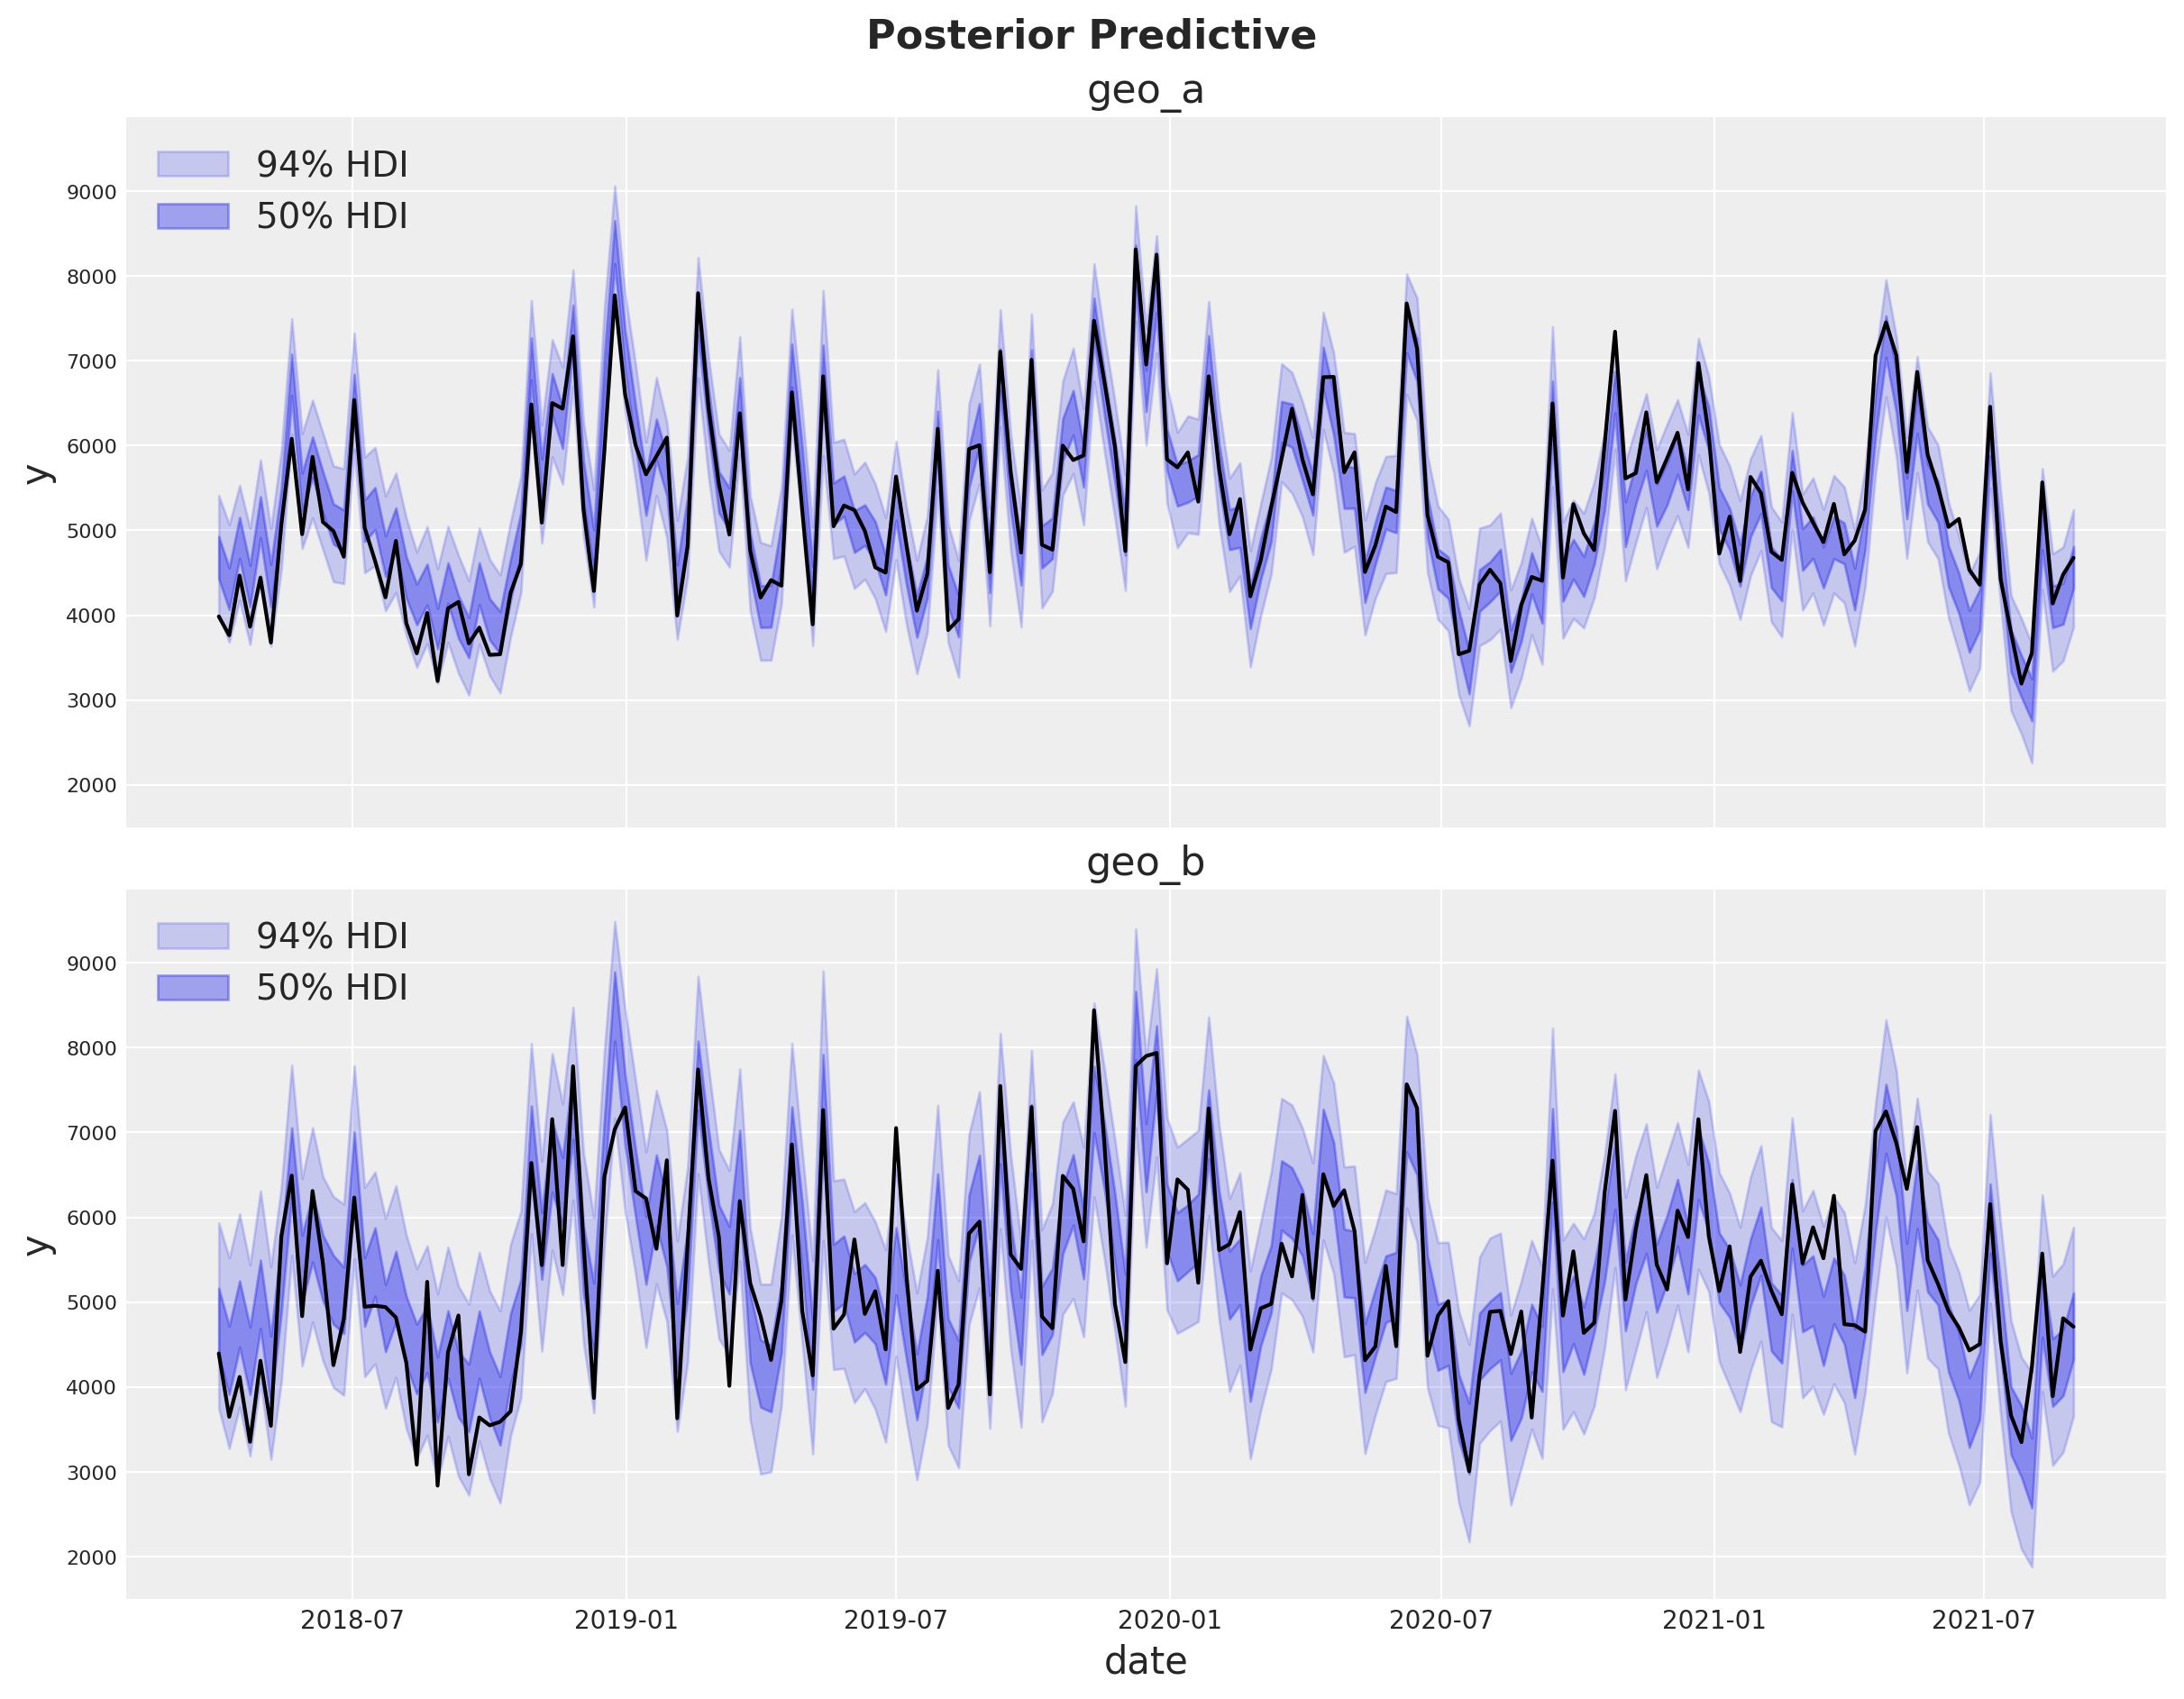

In [20]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(12, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set(title=f"{geo}")

fig.suptitle("Posterior Predictive", fontsize=16, fontweight="bold", y=1.03);

In [21]:
def compute_performance_metrics_by_geo(predicted, actual):
    """
    Computes R², MAPE, and Durbin-Watson stats for each geo.

    Parameters:
        ds (xarray.Dataset): Dataset with coords (geo, time) and variables: expected, actual

    Returns:
        pd.DataFrame: Table with columns: geo, R², MAPE (%), Durbin-Watson
    """
    results = []

    for geo in mmm.model.coords["geo"]:
        try:
            expected = predicted.mean(['chain','draw']).sel(geo = geo)
            actual_vals = actual.loc[actual["geo"] == geo, "y"]

            expected_vals = expected.values
            actual_vals = actual_vals.values

            mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
            expected_vals = expected_vals[mask]
            actual_vals = actual_vals[mask]

            if len(expected_vals) < 3:
                continue  # not enough data

            # R² (manual)
            ss_res = np.sum((actual_vals - expected_vals) ** 2)
            ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

            # MAPE
            nonzero_mask = actual_vals != 0
            mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

            # Durbin-Watson
            residuals = actual_vals - expected_vals
            dw = durbin_watson(residuals)

            results.append({
                "geo": geo,
                "R²": round(r2, 4) if not np.isnan(r2) else None,
                "MAPE (%)": round(mape, 2),
                "Durbin-Watson": round(dw, 3)
            })

        except Exception as e:
            print(f"Error for geo={geo}: {e}")
            continue

    return pd.DataFrame(results).sort_values("geo")
    
performance_table = compute_performance_metrics_by_geo(mmm.idata["posterior_predictive"].y_original_scale, data_df)

display(performance_table)

,geo,R²,MAPE (%),Durbin-Watson
0,geo_a,0.9001,5.47,0.966
1,geo_b,0.7649,9.24,1.757


## Media Effectiveness Recovery

In [22]:
# Read true contributions
# true_contributions = pd.read_csv("true_output_data.csv")

Example true contributions, to be replaced with the actuals upon Luca generating the data.

In [23]:
# ---------------------------TO BE DELETED ----------------------------
contrib_df = data_df.copy()

channel_cols = [col for col in contrib_df.columns if col.startswith("x")]

for col in channel_cols:
    scaling = np.random.uniform(1000, 2000)
    contrib_df[col] = contrib_df[col] * scaling

long_contrib_df = contrib_df.melt(
    id_vars=["date", "geo"],
    value_vars=[col for col in channel_cols],
    var_name="media_channel",
    value_name="contribution"
)

long_contrib_df["media_channel"] = long_contrib_df["media_channel"]

long_contrib_df["date"] = pd.to_datetime(long_contrib_df["date"])

true_contributions_da = (
    long_contrib_df
    .set_index(["date", "geo", "media_channel"])
    .to_xarray()
)["contribution"]

true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
# ---------------------------------------------------------------------

In [24]:
predicted_contributions_ds = mmm.idata["posterior"]["channel_contribution_original_scale"]

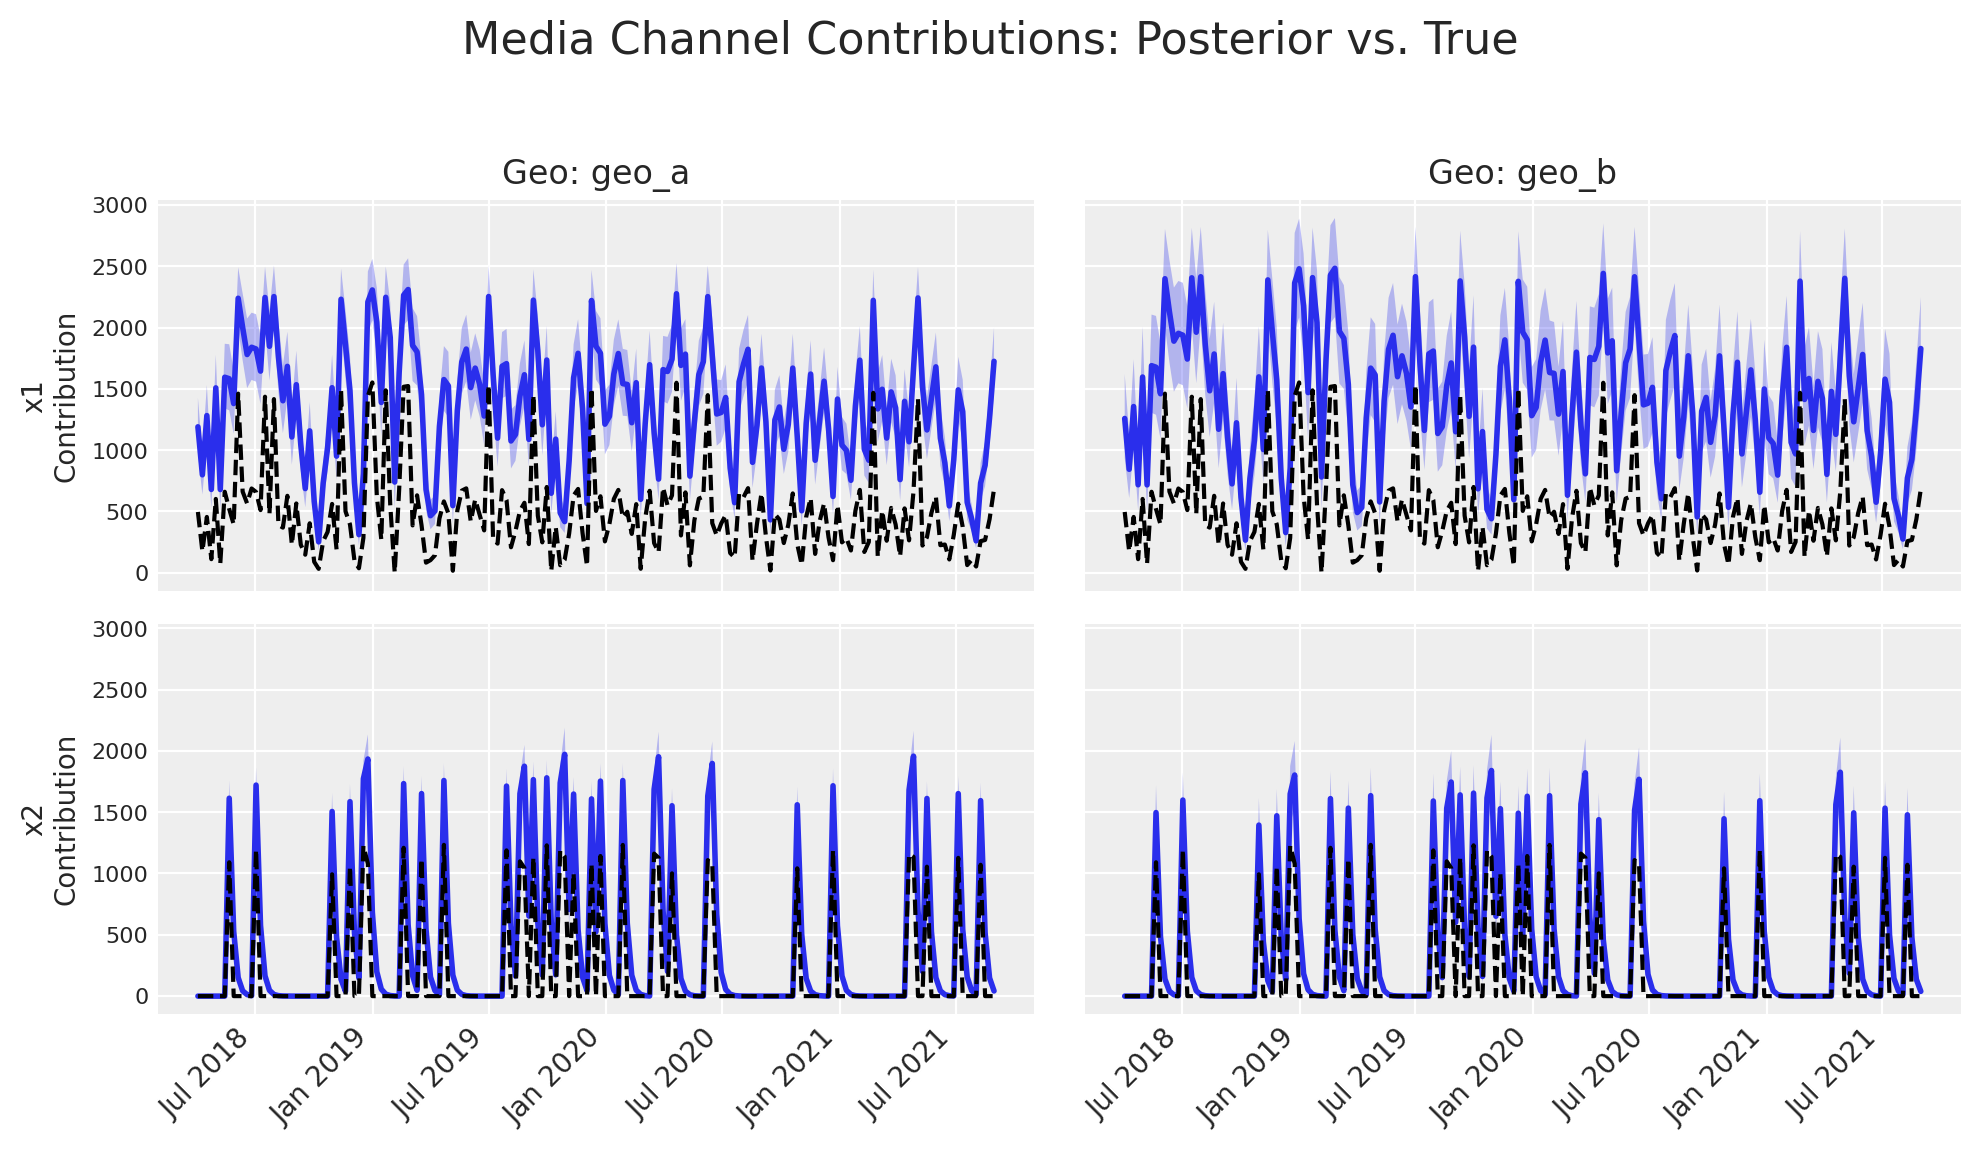

In [25]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (3rd–97th percentiles), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Dataset with dims (chain, draw, date, geo, channel)
        true_contributions_ds (xarray.Dataset): Dataset with dims (date, geo, channel)
    """
    # Extract data
    da = predicted_contributions_ds

    # Collapse (chain, draw) into posterior samples axis
    stacked = da.stack(sample=("chain", "draw"))

    # Compute posterior mean and HDI bounds
    mean = stacked.mean(dim="sample")
    lower = stacked.quantile(0.03, dim="sample")
    upper = stacked.quantile(0.97, dim="sample")

    geos = da.coords["geo"].values
    channels = da.coords["channel"].values
    dates = pd.to_datetime(da.coords["date"].values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axs = np.atleast_2d(axs)

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            mean_ts = mean.sel(geo=geo, channel=channel)
            lower_ts = lower.sel(geo=geo, channel=channel)
            upper_ts = upper.sel(geo=geo, channel=channel)

            ax.plot(dates, mean_ts, label="Mean", linewidth=2)
            ax.fill_between(dates, lower_ts, upper_ts, alpha=0.3, label="HDI (3%–97%)")

            # Plot true contributions
            try:
                truth = true_contributions_ds["contribution"].sel(geo=geo, media_channel=channel)
                truth = truth.sel(date=dates)
                ax.plot(dates, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds)

In [26]:
def compute_mape_table(predicted_ds, true_ds):
    """
    Computes MAPE (%) between predicted and true contributions for each (geo, channel) pair.

    Parameters:
        predicted_ds (xarray.Dataset): dims (chain, draw, date, geo, channel)
        true_ds (xarray.Dataset): dims (date, geo, media_channel)

    Returns:
        pd.DataFrame: Table with columns: geo, channel, MAPE (%)
    """
    pred_mean = predicted_ds.mean(dim=["chain", "draw"])

    results = []

    for geo in predicted_ds.geo.values:
        for channel in predicted_ds.channel.values:
            try:
                # Get predicted and true Series indexed by date
                pred = pred_mean.sel(geo=geo, channel=channel)
                true = true_ds['contribution'].sel(geo=geo, media_channel=channel)

                # Ensure time alignment
                pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                true_series = pd.Series(true.values, index=pd.to_datetime(true["date"].values))

                # Join on time
                df = pred_series.to_frame("pred").join(true_series.to_frame("true"), how="inner")
                df = df.dropna()
                df = df[df["true"] != 0]

                if not df.empty:
                    mape = (np.abs((df["true"] - df["pred"]) / df["true"])).mean() * 100
                    results.append({
                        "geo": geo,
                        "channel": channel,
                        "MAPE (%)": round(mape, 2)
                    })
            except KeyError:
                continue

    return pd.DataFrame(results).sort_values(["geo", "channel"])
mape_df = compute_mape_table(predicted_contributions_ds, true_contributions_ds)
display(mape_df)


,geo,channel,MAPE (%)
0,geo_a,x1,614.03
1,geo_a,x2,53.43
2,geo_b,x1,654.60
3,geo_b,x2,42.57
